# ISPR 2025 - Midterm 3 - Assignament 2 - Gianluca Panzani (550358)

In [23]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms

## Util methods

In [24]:
def get_img(img_dir: str, prefix: str, index: int, postfix: str, mask=False) -> Image:
    zeros = '00' if index < 10 else '0' if index < 100 else ''
    full_path = f'{img_dir}{prefix}{zeros}{index}{postfix}'
    if not mask:
        return Image.open(full_path).convert('RGB')
    return Image.open(full_path).convert('L')

def from_img_to_tensor(img: Image, resize_shape: tuple, mean=None, std=None) -> torch.Tensor:
    if mean is not None and std is not None:
        if not (len(mean) == 3 and len(std) == 3):
            raise ValueError('The image has 3 channles. The parameters "mean" and "std" have to be of length equal to 3.')
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor(), # Scaling
            transforms.Normalize(mean, std) # Normalization
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor() # Scaling
        ])
    return transform(img)
    
def from_mask_to_tensor(img: Image, resize_shape: tuple) -> torch.Tensor:
    transform = transforms.Compose([
        transforms.Resize(resize_shape), # Resize
        transforms.ToTensor(), # Scaling
    ])
    img = transform(img)
    return (img > 0.5).float() # Binarization

def get_mean_and_std(images_dir: str, img_prefix: str, img_postfix: str, resize_shape: tuple):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    i = 0
    while True:
        i += 1
        try:
            image = get_img(img_dir=images_dir, prefix=img_prefix, index=i, postfix=img_postfix, mask=False)
        except:
            break
        img = from_img_to_tensor(img=image, resize_shape=resize_shape)
        mean += img.mean(dim=(1, 2)) # Mean computed on each channel (e.g. with RGB -> [meanR,meanG,meanB])
        std += img.std(dim=(1, 2)) # Std computed on each channel (e.g. with RGB -> [stdR,stdG,stdB])
    mean = (mean / (i-1)).tolist()
    std = (std / (i-1)).tolist()
    return mean, std

## Dataset class definition

In [25]:
class HorseSegmentationDataset(Dataset):
    def __init__(self, images_dir, img_prefix, img_postfix, masks_dir, mask_prefix, mask_postfix, resize_shape=(128,128)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.resize_shape = resize_shape
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.img_postfix = img_postfix
        self.mask_postfix = mask_postfix
        self.length = len(os.listdir(images_dir))
        mean, std = get_mean_and_std(
            images_dir=self.images_dir,
            img_prefix=self.img_prefix,
            img_postfix=self.img_postfix,
            resize_shape=self.resize_shape
        )
        self.mean = mean
        self.std = std

    def __getitem__(self, index):
        img = get_img(self.images_dir, self.img_prefix, index+1, self.img_postfix, mask=False)
        mask = get_img(self.masks_dir, self.mask_prefix, index+1, self.mask_postfix, mask=True)
        img_tensor = from_img_to_tensor(img, self.resize_shape, self.mean, self.std)
        mask_tensor = from_mask_to_tensor(mask, self.resize_shape)
        return img_tensor, mask_tensor
    
    def __len__(self):
        return self.length



# Creation of the dataset object
dataset = HorseSegmentationDataset(
    images_dir='weizmann_horse_db/horse/',
    img_prefix='horse',
    img_postfix='.png',
    masks_dir='weizmann_horse_db/mask/',
    mask_prefix='horse',
    mask_postfix='.png',
    resize_shape=(128,128)
)

In [26]:
class SegmentationCNN(nn.Module):
    def __init__(self,
                 encoder_channels: list[int],
                 decoder_channels: list[int],
                 encoder_kernel_sizes: list[int],
                 decoder_kernel_sizes: list[int],
                 encoder_strides: list[int],
                 decoder_strides: list[int],
                 output_padding: int):
        super(SegmentationCNN, self).__init__()
        # Encoder architecture
        layers = []
        for i in range(len(encoder_channels)-1):
            k = encoder_kernel_sizes[i]
            s = encoder_strides[i]
            layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=k, stride=s, padding=k//2))
            layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*layers)
        # Decoder architecture
        layers = []
        for i in range(len(decoder_channels)-2):
            k = decoder_kernel_sizes[i]
            s = decoder_strides[i]
            layers.append(nn.ConvTranspose2d(decoder_channels[i], decoder_channels[i+1], kernel_size=k, stride=s, padding=k, output_padding=output_padding))
            layers.append(nn.ReLU())
        layers.append(nn.ConvTranspose2d(decoder_channels[-2], decoder_channels[-1], kernel_size=decoder_kernel_sizes[-1], stride=decoder_strides[-1]))
        layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        return x

## Grid search
The best hyperparameters are searched with the Grid search technique.

In [27]:
def get_params_combinations(params: dict) -> list[dict]:
    '''
    Creates and saves into the class instance a list with all the possible combinations of parameters \
    in the dictionary "params".

    Parameters:
    - params: dictionary with the parameters as associations <key:values> (with: key=parameter_name,
    values=possible_values_list).

    Returns:
    A list of dictionaries such that each one represents a combination of parameters (1 combination = 1 dictionary).
    '''
    params_index_dict = {}
    params_combinations = []
    for key in params.keys():
        params_index_dict[key] = 0 # current_index for that key
    while sum([index+1 for _, index in params_index_dict.items()]) != sum(len(val_list) for _, val_list in params.items()):
        params_i = {}
        for key, i in params_index_dict.items():
            params_i[key] = params[key][i]
        params_combinations.append(params_i)
        for key in params_index_dict.keys():
            params_index_dict[key] += 1
            if params_index_dict[key] < len(params[key]):
                break
            params_index_dict[key] = 0
    params_i = {}
    for key, i in params_index_dict.items():
        params_i[key] = params[key][i]
    params_combinations.append(params_i)
    return params_combinations


# Space of the hyperparameters
params_space = {
    'batch_size': [8, 16],
    'learning_rate': [0.0001, 0.001],
    'epochs': [10, 30],
    'architecture': [
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,3], 'encoder_strides': [2,2,1],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [3,3,3], 'decoder_strides': [2,2,1],
            'output_padding': 1
        },
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,3], 'encoder_strides': [2,2,2],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [2,2,2], 'decoder_strides': [2,2,2],
            'output_padding': 1
        },
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [5,5,5], 'encoder_strides': [2,2,2],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [4,4,4], 'decoder_strides': [2,2,2],
            'output_padding': 1
        }
    ]
}

## Training and Testing methods

In [28]:
def show_plot(tr_losses: list, vl_losses: list):
    plt.plot(tr_losses, label='Training Loss')
    plt.plot(vl_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss functions')
    plt.show()


def train(model: nn.Module, tr_dataloader: DataLoader, vl_dataloader: DataLoader, optimizer, criterion, device, epochs, verbose=1):
    model.to(device)
    model.train()

    # Initializations
    threshold = 0.0001
    patience = 0
    prev_vl_loss = 1
    tr_losses = []
    vl_losses = []

    # Iterate on the epochs
    for epoch in range(epochs):
        total_loss = 0.0

        # Iterate on the batches (of the training set)
        for imgs, masks in tr_dataloader:
            imgs = imgs.to(device)          # Move images' tensors on GPU or CPU
            masks = masks.to(device)        # Move masks' tensors on GPU or CPU

            preds = model(imgs)             # Compute the predictions
            loss = criterion(preds, masks)  # Compute the loss
            optimizer.zero_grad()           # Reset the gradients
            loss.backward()                 # Perform backpropagation
            optimizer.step()                # Update model's parameters (based on gradients)

            total_loss += loss.item()       # Update total loss with the average loss on this batch

        # Compute the average loss on the epoch
        tr_avg_loss = total_loss / len(tr_dataloader)
        tr_losses.append(tr_avg_loss)

        # Start validation phase
        model.eval()

        # Disable the update of the gradients
        with torch.no_grad():
            total_loss = 0.0

            # Iterations on the batches (of the validation set)
            for imgs, masks in vl_dataloader:
                imgs = imgs.to(device)
                masks = masks.to(device)

                preds = model(imgs)
                loss = criterion(preds, masks)

                total_loss += loss.item()

        vl_avg_loss = total_loss / len(vl_dataloader)
        vl_losses.append(vl_avg_loss)

        # Early stopping
        if abs(prev_vl_loss - vl_avg_loss) < threshold:
            patience += 1
        else:
            patience = 0
        if patience > 5:
            break
        prev_vl_loss = vl_avg_loss

        # Print of the epoch result
        if verbose > 0:
            print(f'Epoch {epoch+1}/{epochs}: TR_loss={tr_avg_loss:.5f} - VL_loss={vl_avg_loss:.5f}')
    
    return tr_losses, vl_losses


def evaluate(model: nn.Module, ts_dataloader: DataLoader, criterion, device):
    model.eval()
    model.to(device)

    # Initializations
    total_correct = 0
    total_pixels = 0
    total_loss = 0.0

    with torch.no_grad():
        for imgs, masks in ts_dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            # Compute the predictions and the loss
            preds = model(imgs)
            loss = criterion(preds, masks)
            total_loss += loss.item()

            # Binarization of the predictions
            preds = (preds > 0.5).float()

            # Compute the number of correct pixels predicted
            total_correct += (preds == masks).sum().item()
            total_pixels += torch.numel(preds)

    # Accuracy and average loss
    accuracy = total_correct / total_pixels
    avg_loss = total_loss / len(ts_dataloader)

    return accuracy, avg_loss

## Model selection

Hyperparameters [1/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.55330 - VL_loss=0.47535
Epoch 2/10: TR_loss=0.38195 - VL_loss=0.25015
Epoch 3/10: TR_loss=0.15546 - VL_loss=0.07560
Epoch 4/10: TR_loss=0.05450 - VL_loss=0.03203
Epoch 5/10: TR_loss=0.02688 - VL_loss=0.01817
Epoch 6/10: TR_loss=0.01638 - VL_loss=0.01198
Epoch 7/10: TR_loss=0.01121 - VL_loss=0.00869
Epoch 8/10: TR_loss=0.00827 - VL_loss=0.00665
Epoch 9/10: TR_loss=0.00640 - VL_loss=0.00536
Epoch 10/10: TR_loss=0.00515 - VL_loss=0.00441


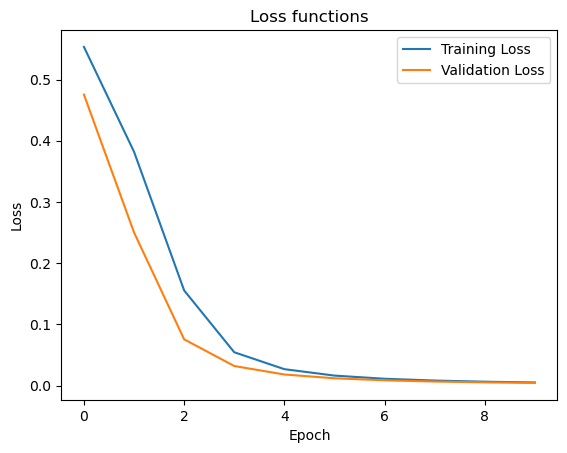

Hyperparameters [2/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.78418 - VL_loss=0.68214
Epoch 2/10: TR_loss=0.60332 - VL_loss=0.48516
Epoch 3/10: TR_loss=0.40037 - VL_loss=0.27154
Epoch 4/10: TR_loss=0.21176 - VL_loss=0.12654
Epoch 5/10: TR_loss=0.10490 - VL_loss=0.06539
Epoch 6/10: TR_loss=0.05857 - VL_loss=0.04015
Epoch 7/10: TR_loss=0.03690 - VL_loss=0.02766
Epoch 8/10: TR_loss=0.02631 - VL_loss=0.02057
Epoch 9/10: TR_loss=0.01923 - VL_loss=0.01590
Epoch 10/10: TR_loss=0.01517 - VL_loss=0.01263


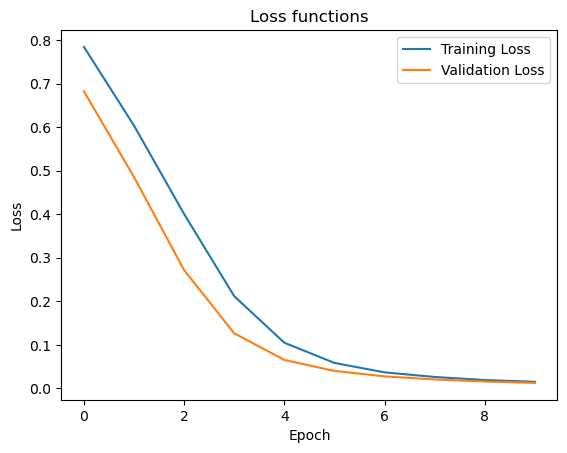

Hyperparameters [3/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.18325 - VL_loss=0.00205
Epoch 2/10: TR_loss=0.00102 - VL_loss=0.00077
Epoch 3/10: TR_loss=0.00050 - VL_loss=0.00054
Epoch 4/10: TR_loss=0.00033 - VL_loss=0.00037
Epoch 5/10: TR_loss=0.00020 - VL_loss=0.00025
Epoch 6/10: TR_loss=0.00013 - VL_loss=0.00017
Epoch 7/10: TR_loss=0.00009 - VL_loss=0.00013
Epoch 8/10: TR_loss=0.00006 - VL_loss=0.00010
Epoch 9/10: TR_loss=0.00005 - VL_loss=0.00008
Epoch 10/10: TR_loss=0.00003 - VL_loss=0.00006


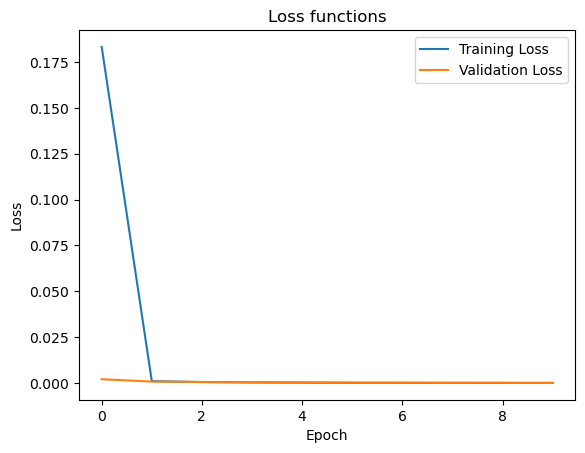

Hyperparameters [4/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.23174 - VL_loss=0.00783
Epoch 2/10: TR_loss=0.00322 - VL_loss=0.00102
Epoch 3/10: TR_loss=0.00060 - VL_loss=0.00054
Epoch 4/10: TR_loss=0.00036 - VL_loss=0.00042
Epoch 5/10: TR_loss=0.00028 - VL_loss=0.00037
Epoch 6/10: TR_loss=0.00023 - VL_loss=0.00032
Epoch 7/10: TR_loss=0.00020 - VL_loss=0.00029
Epoch 8/10: TR_loss=0.00017 - VL_loss=0.00025
Epoch 9/10: TR_loss=0.00015 - VL_loss=0.00022


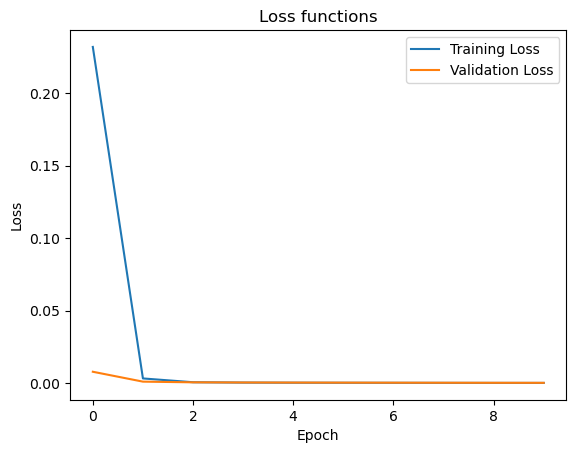

Hyperparameters [5/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.43649 - VL_loss=0.29369
Epoch 2/30: TR_loss=0.18014 - VL_loss=0.08285
Epoch 3/30: TR_loss=0.05370 - VL_loss=0.02931
Epoch 4/30: TR_loss=0.02342 - VL_loss=0.01664
Epoch 5/30: TR_loss=0.01441 - VL_loss=0.01140
Epoch 6/30: TR_loss=0.01020 - VL_loss=0.00856
Epoch 7/30: TR_loss=0.00768 - VL_loss=0.00677
Epoch 8/30: TR_loss=0.00608 - VL_loss=0.00556
Epoch 9/30: TR_loss=0.00494 - VL_loss=0.00466
Epoch 10/30: TR_loss=0.00416 - VL_loss=0.00400
Epoch 11/30: TR_loss=0.00348 - VL_loss=0.00347
Epoch 12/30: TR_loss=0.00299 - VL_loss=0.00306
Epoch 13/30: TR_loss=0.00260 - VL_loss=0.00272
Epoch 14/30: TR_loss=0.00229 - VL_loss=0.00244
Epoch 15/30: TR_loss=0.00201 - VL_l

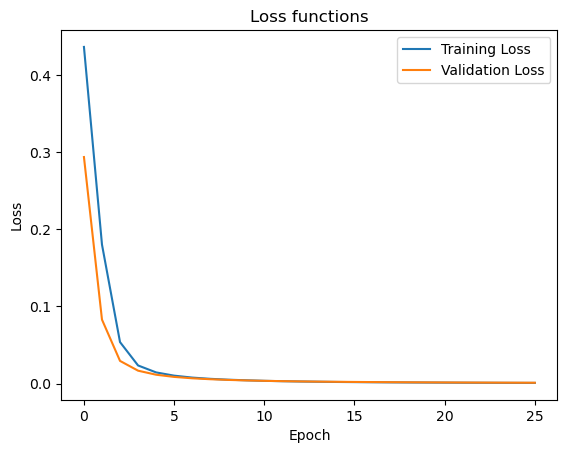

Hyperparameters [6/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.74617 - VL_loss=0.64555
Epoch 2/30: TR_loss=0.55895 - VL_loss=0.42434
Epoch 3/30: TR_loss=0.33541 - VL_loss=0.21668
Epoch 4/30: TR_loss=0.17018 - VL_loss=0.10231
Epoch 5/30: TR_loss=0.08470 - VL_loss=0.05653
Epoch 6/30: TR_loss=0.05030 - VL_loss=0.03706
Epoch 7/30: TR_loss=0.03433 - VL_loss=0.02710
Epoch 8/30: TR_loss=0.02520 - VL_loss=0.02110
Epoch 9/30: TR_loss=0.02004 - VL_loss=0.01708
Epoch 10/30: TR_loss=0.01572 - VL_loss=0.01416
Epoch 11/30: TR_loss=0.01300 - VL_loss=0.01200
Epoch 12/30: TR_loss=0.01104 - VL_loss=0.01036
Epoch 13/30: TR_loss=0.00924 - VL_loss=0.00907
Epoch 14/30: TR_loss=0.00798 - VL_loss=0.00805
Epoch 15/30: TR_loss=0.00707 - VL_

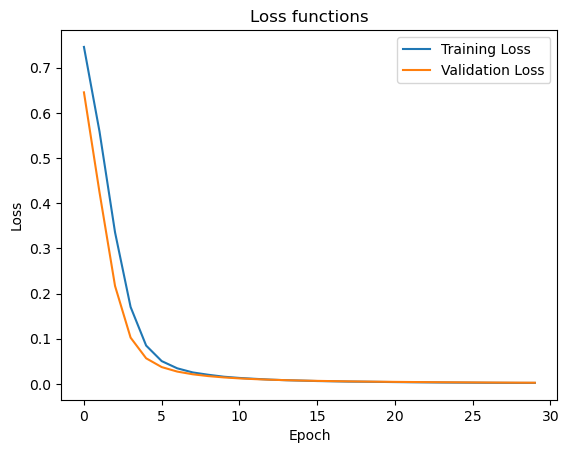

Hyperparameters [7/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.08143 - VL_loss=0.00073
Epoch 2/30: TR_loss=0.00043 - VL_loss=0.00028
Epoch 3/30: TR_loss=0.00017 - VL_loss=0.00012
Epoch 4/30: TR_loss=0.00008 - VL_loss=0.00007
Epoch 5/30: TR_loss=0.00005 - VL_loss=0.00005
Epoch 6/30: TR_loss=0.00003 - VL_loss=0.00004
Epoch 7/30: TR_loss=0.00002 - VL_loss=0.00003
Epoch 8/30: TR_loss=0.00002 - VL_loss=0.00003


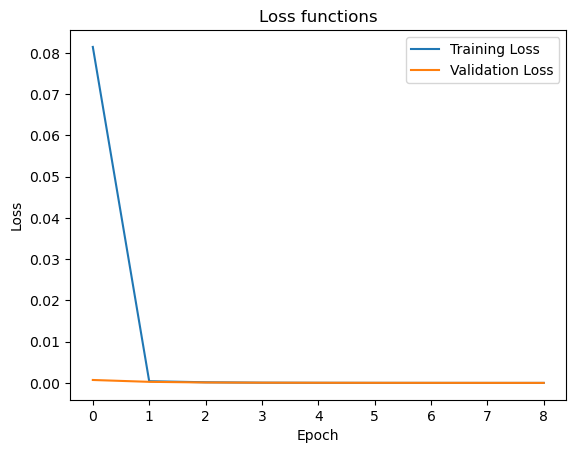

Hyperparameters [8/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 1], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [3, 3, 3], 'decoder_strides': [2, 2, 1], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.25430 - VL_loss=0.01410
Epoch 2/30: TR_loss=0.00570 - VL_loss=0.00216
Epoch 3/30: TR_loss=0.00138 - VL_loss=0.00111
Epoch 4/30: TR_loss=0.00080 - VL_loss=0.00082
Epoch 5/30: TR_loss=0.00062 - VL_loss=0.00067
Epoch 6/30: TR_loss=0.00046 - VL_loss=0.00056
Epoch 7/30: TR_loss=0.00038 - VL_loss=0.00048
Epoch 8/30: TR_loss=0.00031 - VL_loss=0.00042
Epoch 9/30: TR_loss=0.00027 - VL_loss=0.00036
Epoch 10/30: TR_loss=0.00023 - VL_loss=0.00032
Epoch 11/30: TR_loss=0.00019 - VL_loss=0.00028


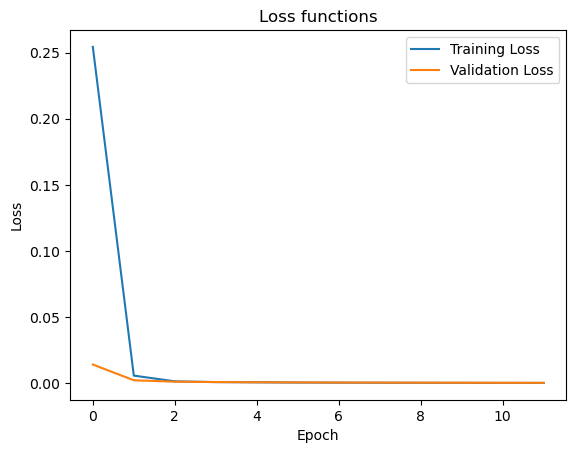

Hyperparameters [9/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.87913 - VL_loss=0.83585
Epoch 2/10: TR_loss=0.76626 - VL_loss=0.66279
Epoch 3/10: TR_loss=0.53527 - VL_loss=0.38974
Epoch 4/10: TR_loss=0.29613 - VL_loss=0.19582
Epoch 5/10: TR_loss=0.16066 - VL_loss=0.10772
Epoch 6/10: TR_loss=0.09816 - VL_loss=0.06728
Epoch 7/10: TR_loss=0.06581 - VL_loss=0.04519
Epoch 8/10: TR_loss=0.04598 - VL_loss=0.03208
Epoch 9/10: TR_loss=0.03392 - VL_loss=0.02370
Epoch 10/10: TR_loss=0.02552 - VL_loss=0.01797


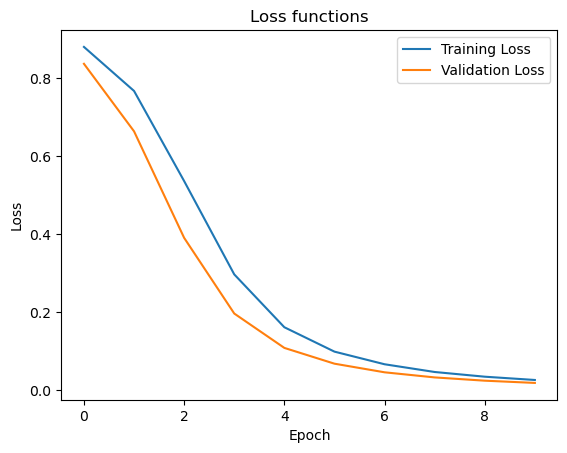

Hyperparameters [10/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.70486 - VL_loss=0.68096
Epoch 2/10: TR_loss=0.66594 - VL_loss=0.63733
Epoch 3/10: TR_loss=0.61970 - VL_loss=0.57834
Epoch 4/10: TR_loss=0.55509 - VL_loss=0.50218
Epoch 5/10: TR_loss=0.47690 - VL_loss=0.41475
Epoch 6/10: TR_loss=0.39042 - VL_loss=0.32461
Epoch 7/10: TR_loss=0.30551 - VL_loss=0.24322
Epoch 8/10: TR_loss=0.22951 - VL_loss=0.17700
Epoch 9/10: TR_loss=0.17330 - VL_loss=0.12835
Epoch 10/10: TR_loss=0.12855 - VL_loss=0.09488


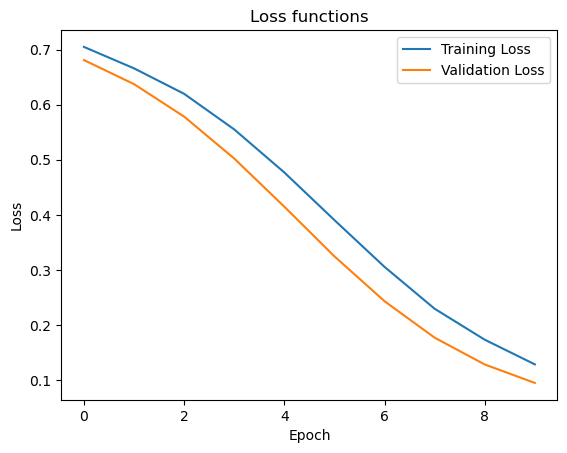

Hyperparameters [11/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.31886 - VL_loss=0.01272
Epoch 2/10: TR_loss=0.00474 - VL_loss=0.00132
Epoch 3/10: TR_loss=0.00116 - VL_loss=0.00070
Epoch 4/10: TR_loss=0.00064 - VL_loss=0.00038
Epoch 5/10: TR_loss=0.00035 - VL_loss=0.00019
Epoch 6/10: TR_loss=0.00019 - VL_loss=0.00010
Epoch 7/10: TR_loss=0.00011 - VL_loss=0.00006
Epoch 8/10: TR_loss=0.00007 - VL_loss=0.00004
Epoch 9/10: TR_loss=0.00005 - VL_loss=0.00003
Epoch 10/10: TR_loss=0.00004 - VL_loss=0.00002


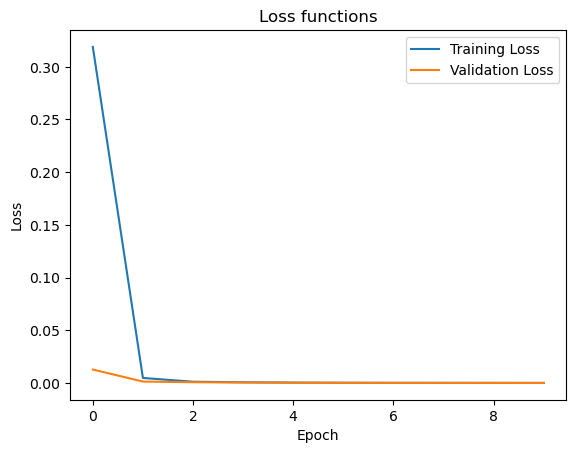

Hyperparameters [12/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.55271 - VL_loss=0.28326
Epoch 2/10: TR_loss=0.12891 - VL_loss=0.02127
Epoch 3/10: TR_loss=0.01199 - VL_loss=0.00364
Epoch 4/10: TR_loss=0.00320 - VL_loss=0.00163
Epoch 5/10: TR_loss=0.00174 - VL_loss=0.00111
Epoch 6/10: TR_loss=0.00123 - VL_loss=0.00087
Epoch 7/10: TR_loss=0.00099 - VL_loss=0.00071
Epoch 8/10: TR_loss=0.00079 - VL_loss=0.00060
Epoch 9/10: TR_loss=0.00065 - VL_loss=0.00050
Epoch 10/10: TR_loss=0.00055 - VL_loss=0.00042


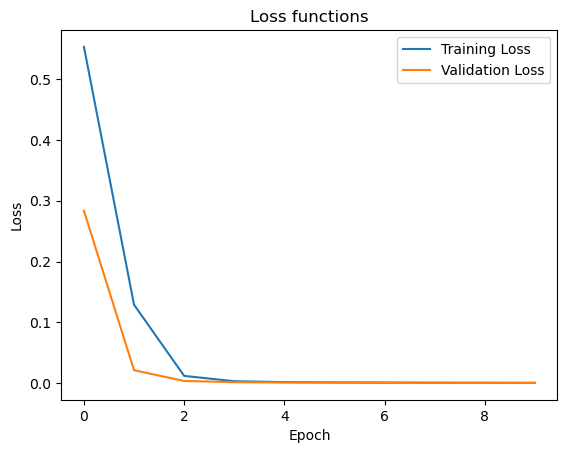

Hyperparameters [13/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.74087 - VL_loss=0.68374
Epoch 2/30: TR_loss=0.60553 - VL_loss=0.48590
Epoch 3/30: TR_loss=0.38343 - VL_loss=0.25614
Epoch 4/30: TR_loss=0.20072 - VL_loss=0.12609
Epoch 5/30: TR_loss=0.10785 - VL_loss=0.07063
Epoch 6/30: TR_loss=0.06631 - VL_loss=0.04502
Epoch 7/30: TR_loss=0.04451 - VL_loss=0.03095
Epoch 8/30: TR_loss=0.03194 - VL_loss=0.02269
Epoch 9/30: TR_loss=0.02382 - VL_loss=0.01705
Epoch 10/30: TR_loss=0.01829 - VL_loss=0.01343
Epoch 11/30: TR_loss=0.01469 - VL_loss=0.01075
Epoch 12/30: TR_loss=0.01177 - VL_loss=0.00872
Epoch 13/30: TR_loss=0.00971 - VL_loss=0.00727
Epoch 14/30: TR_loss=0.00814 - VL_loss=0.00611
Epoch 15/30: TR_loss=0.00693 - VL_

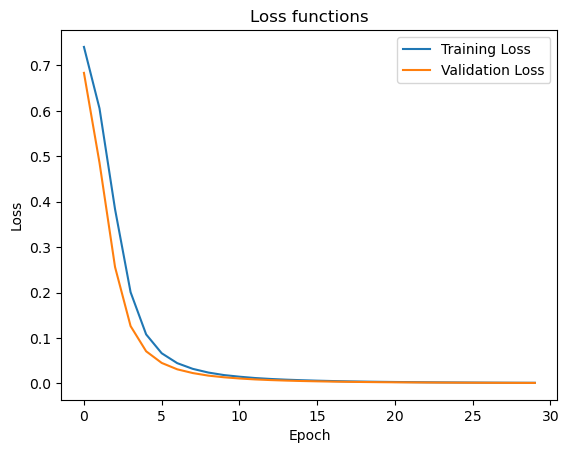

Hyperparameters [14/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.88780 - VL_loss=0.87217
Epoch 2/30: TR_loss=0.85979 - VL_loss=0.84480
Epoch 3/30: TR_loss=0.82902 - VL_loss=0.80477
Epoch 4/30: TR_loss=0.77881 - VL_loss=0.73991
Epoch 5/30: TR_loss=0.69908 - VL_loss=0.63943
Epoch 6/30: TR_loss=0.58750 - VL_loss=0.50978
Epoch 7/30: TR_loss=0.45624 - VL_loss=0.37415
Epoch 8/30: TR_loss=0.33951 - VL_loss=0.26196
Epoch 9/30: TR_loss=0.24245 - VL_loss=0.18390
Epoch 10/30: TR_loss=0.17411 - VL_loss=0.13345
Epoch 11/30: TR_loss=0.13184 - VL_loss=0.10037
Epoch 12/30: TR_loss=0.10352 - VL_loss=0.07829
Epoch 13/30: TR_loss=0.08211 - VL_loss=0.06279
Epoch 14/30: TR_loss=0.06711 - VL_loss=0.05170
Epoch 15/30: TR_loss=0.05508 - VL

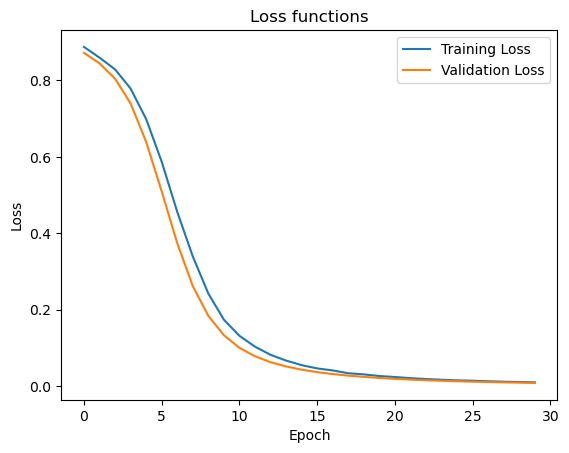

Hyperparameters [15/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.35182 - VL_loss=0.01926
Epoch 2/30: TR_loss=0.00745 - VL_loss=0.00150
Epoch 3/30: TR_loss=0.00145 - VL_loss=0.00082
Epoch 4/30: TR_loss=0.00092 - VL_loss=0.00059
Epoch 5/30: TR_loss=0.00065 - VL_loss=0.00041
Epoch 6/30: TR_loss=0.00039 - VL_loss=0.00018
Epoch 7/30: TR_loss=0.00017 - VL_loss=0.00008
Epoch 8/30: TR_loss=0.00008 - VL_loss=0.00004
Epoch 9/30: TR_loss=0.00005 - VL_loss=0.00002
Epoch 10/30: TR_loss=0.00003 - VL_loss=0.00002
Epoch 11/30: TR_loss=0.00002 - VL_loss=0.00001
Epoch 12/30: TR_loss=0.00002 - VL_loss=0.00001


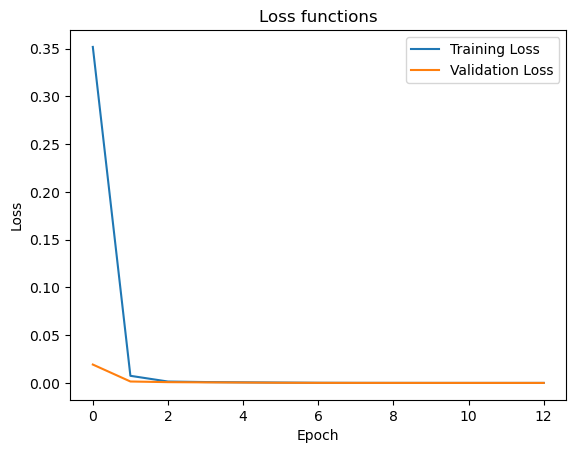

Hyperparameters [16/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.41941 - VL_loss=0.14182
Epoch 2/30: TR_loss=0.05223 - VL_loss=0.00652
Epoch 3/30: TR_loss=0.00395 - VL_loss=0.00134
Epoch 4/30: TR_loss=0.00121 - VL_loss=0.00073
Epoch 5/30: TR_loss=0.00079 - VL_loss=0.00056
Epoch 6/30: TR_loss=0.00064 - VL_loss=0.00047
Epoch 7/30: TR_loss=0.00057 - VL_loss=0.00040
Epoch 8/30: TR_loss=0.00047 - VL_loss=0.00035
Epoch 9/30: TR_loss=0.00042 - VL_loss=0.00031
Epoch 10/30: TR_loss=0.00036 - VL_loss=0.00027


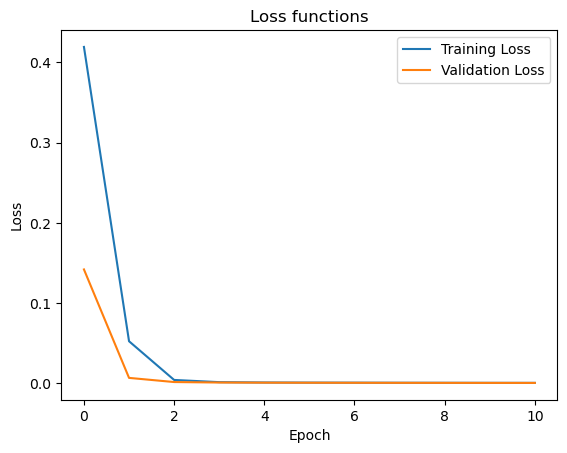

Hyperparameters [17/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [5, 5, 5], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [4, 4, 4], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.67099 - VL_loss=0.41710
Epoch 2/10: TR_loss=0.20584 - VL_loss=0.05246
Epoch 3/10: TR_loss=0.03378 - VL_loss=0.01742
Epoch 4/10: TR_loss=0.01473 - VL_loss=0.00979
Epoch 5/10: TR_loss=0.00881 - VL_loss=0.00632
Epoch 6/10: TR_loss=0.00590 - VL_loss=0.00429
Epoch 7/10: TR_loss=0.00403 - VL_loss=0.00302
Epoch 8/10: TR_loss=0.00287 - VL_loss=0.00225
Epoch 9/10: TR_loss=0.00216 - VL_loss=0.00176
Epoch 10/10: TR_loss=0.00168 - VL_loss=0.00140


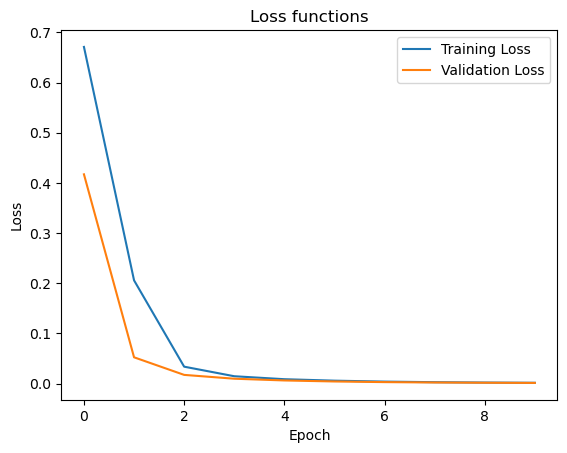

Hyperparameters [18/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [5, 5, 5], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [4, 4, 4], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.62772 - VL_loss=0.54863
Epoch 2/10: TR_loss=0.45283 - VL_loss=0.32079
Epoch 3/10: TR_loss=0.23121 - VL_loss=0.13452
Epoch 4/10: TR_loss=0.09929 - VL_loss=0.05770
Epoch 5/10: TR_loss=0.04758 - VL_loss=0.03172
Epoch 6/10: TR_loss=0.02884 - VL_loss=0.02112
Epoch 7/10: TR_loss=0.01942 - VL_loss=0.01538
Epoch 8/10: TR_loss=0.01476 - VL_loss=0.01184
Epoch 9/10: TR_loss=0.01124 - VL_loss=0.00940
Epoch 10/10: TR_loss=0.00854 - VL_loss=0.00763


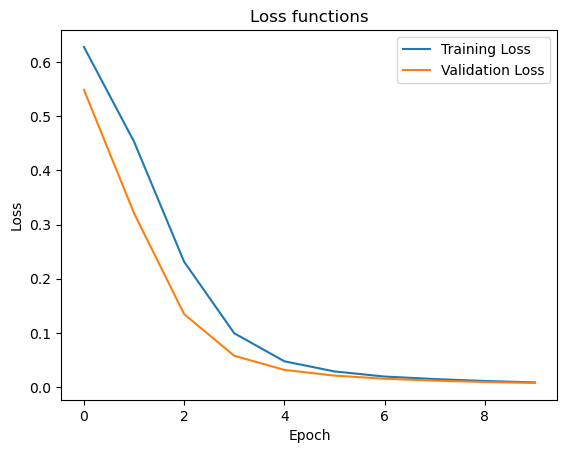

Hyperparameters [19/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [5, 5, 5], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [4, 4, 4], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.15826 - VL_loss=0.00139
Epoch 2/10: TR_loss=0.00089 - VL_loss=0.00068
Epoch 3/10: TR_loss=0.00052 - VL_loss=0.00041
Epoch 4/10: TR_loss=0.00033 - VL_loss=0.00026
Epoch 5/10: TR_loss=0.00023 - VL_loss=0.00020
Epoch 6/10: TR_loss=0.00018 - VL_loss=0.00016
Epoch 7/10: TR_loss=0.00015 - VL_loss=0.00014
Epoch 8/10: TR_loss=0.00013 - VL_loss=0.00012
Epoch 9/10: TR_loss=0.00011 - VL_loss=0.00010


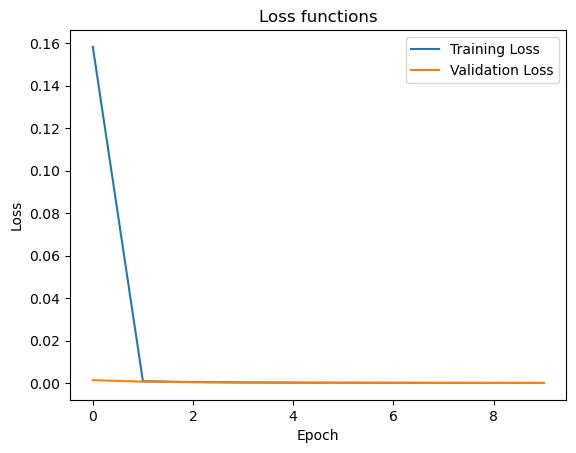

Hyperparameters [20/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 10, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [5, 5, 5], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [4, 4, 4], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/10: TR_loss=0.24911 - VL_loss=0.00461
Epoch 2/10: TR_loss=0.00145 - VL_loss=0.00033
Epoch 3/10: TR_loss=0.00021 - VL_loss=0.00017
Epoch 4/10: TR_loss=0.00013 - VL_loss=0.00013
Epoch 5/10: TR_loss=0.00010 - VL_loss=0.00012
Epoch 6/10: TR_loss=0.00010 - VL_loss=0.00011
Epoch 7/10: TR_loss=0.00009 - VL_loss=0.00010
Epoch 8/10: TR_loss=0.00008 - VL_loss=0.00010


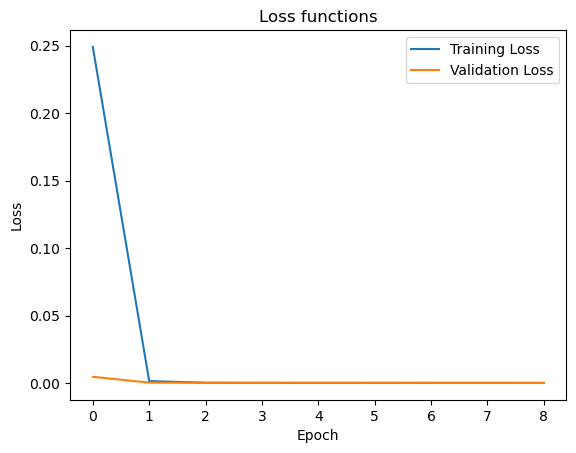

Hyperparameters [21/24]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [5, 5, 5], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [4, 4, 4], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.50912 - VL_loss=0.24083
Epoch 2/30: TR_loss=0.11190 - VL_loss=0.02957
Epoch 3/30: TR_loss=0.02121 - VL_loss=0.01073
Epoch 4/30: TR_loss=0.01013 - VL_loss=0.00641
Epoch 5/30: TR_loss=0.00649 - VL_loss=0.00441
Epoch 6/30: TR_loss=0.00463 - VL_loss=0.00322
Epoch 7/30: TR_loss=0.00348 - VL_loss=0.00245
Epoch 8/30: TR_loss=0.00261 - VL_loss=0.00190
Epoch 9/30: TR_loss=0.00206 - VL_loss=0.00152
Epoch 10/30: TR_loss=0.00162 - VL_loss=0.00123
Epoch 11/30: TR_loss=0.00130 - VL_loss=0.00101
Epoch 12/30: TR_loss=0.00108 - VL_loss=0.00084
Epoch 13/30: TR_loss=0.00091 - VL_loss=0.00071
Epoch 14/30: TR_loss=0.00076 - VL_loss=0.00061
Epoch 15/30: TR_loss=0.00065 - VL_

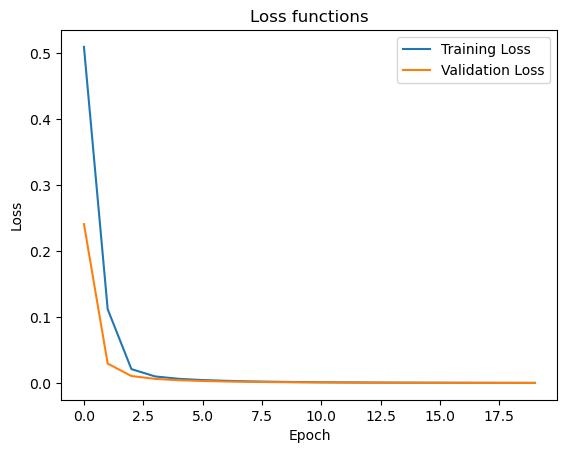

Hyperparameters [22/24]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [5, 5, 5], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [4, 4, 4], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.66850 - VL_loss=0.59427
Epoch 2/30: TR_loss=0.49247 - VL_loss=0.32624
Epoch 3/30: TR_loss=0.22679 - VL_loss=0.09980
Epoch 4/30: TR_loss=0.07624 - VL_loss=0.03546
Epoch 5/30: TR_loss=0.03431 - VL_loss=0.01908
Epoch 6/30: TR_loss=0.02078 - VL_loss=0.01283
Epoch 7/30: TR_loss=0.01487 - VL_loss=0.00968
Epoch 8/30: TR_loss=0.01155 - VL_loss=0.00764
Epoch 9/30: TR_loss=0.00939 - VL_loss=0.00625
Epoch 10/30: TR_loss=0.00764 - VL_loss=0.00517
Epoch 11/30: TR_loss=0.00604 - VL_loss=0.00429
Epoch 12/30: TR_loss=0.00495 - VL_loss=0.00361
Epoch 13/30: TR_loss=0.00432 - VL_loss=0.00306
Epoch 14/30: TR_loss=0.00337 - VL_loss=0.00263
Epoch 15/30: TR_loss=0.00289 - VL

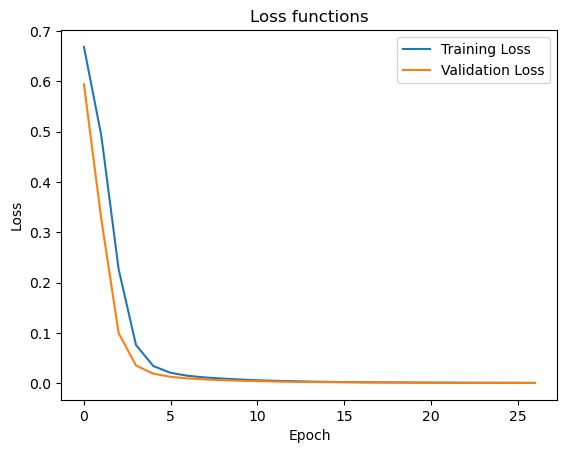

Hyperparameters [23/24]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [5, 5, 5], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [4, 4, 4], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.18128 - VL_loss=0.00380
Epoch 2/30: TR_loss=0.00291 - VL_loss=0.00041
Epoch 3/30: TR_loss=0.00030 - VL_loss=0.00026
Epoch 4/30: TR_loss=0.00024 - VL_loss=0.00022
Epoch 5/30: TR_loss=0.00021 - VL_loss=0.00020
Epoch 6/30: TR_loss=0.00019 - VL_loss=0.00018
Epoch 7/30: TR_loss=0.00015 - VL_loss=0.00011
Epoch 8/30: TR_loss=0.00008 - VL_loss=0.00007


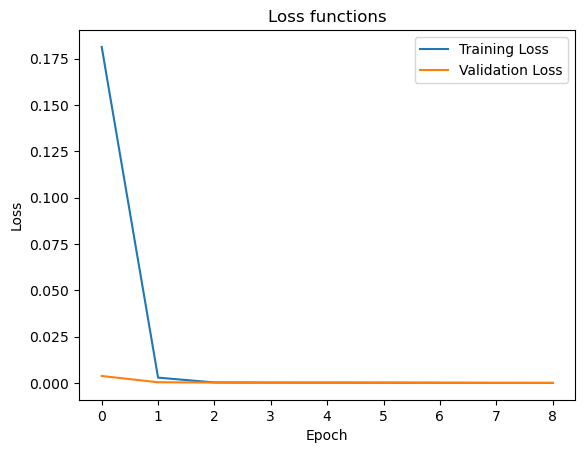

Hyperparameters [24/24]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [5, 5, 5], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [4, 4, 4], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Epoch 1/30: TR_loss=0.23485 - VL_loss=0.00203
Epoch 2/30: TR_loss=0.00065 - VL_loss=0.00018
Epoch 3/30: TR_loss=0.00012 - VL_loss=0.00009
Epoch 4/30: TR_loss=0.00008 - VL_loss=0.00007
Epoch 5/30: TR_loss=0.00007 - VL_loss=0.00007
Epoch 6/30: TR_loss=0.00006 - VL_loss=0.00006
Epoch 7/30: TR_loss=0.00006 - VL_loss=0.00006


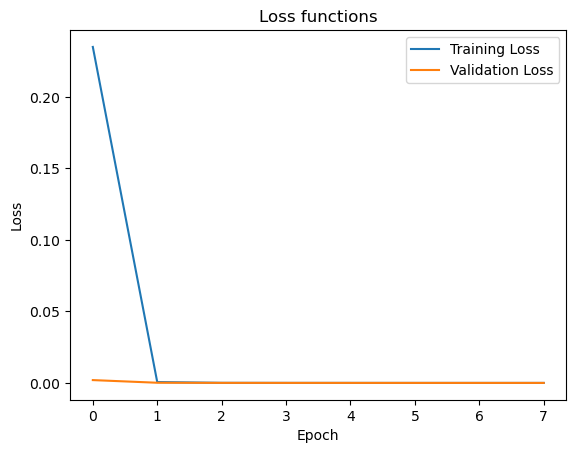

In [29]:
# Iterates on each parameters combination obtained from the parameters space
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.70,0.15,0.15])
params_list = get_params_combinations(params_space)
models = {}
for i, params in enumerate(params_list):
    print(f'Hyperparameters [{i+1}/{len(params_list)}]: {params}')

    # Datasets initializations
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    # Create the model
    model = SegmentationCNN(**params['architecture'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = torch.nn.BCELoss()

    # Training phase
    tr_losses, vl_losses = train(
        model,
        tr_dataloader=train_loader,
        vl_dataloader=val_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        epochs=params['epochs']
    )

    # Insert the model in the dictionary
    models[i] = {
        'model': model,
        'params': params,
        'vl_losses': vl_losses,
        'tr_losses': tr_losses
    }

    # Shows the Loss plots
    show_plot(tr_losses, vl_losses)

# Select the best model (with the lowest validation loss)
best_model_obj = min(models.items(), key=lambda x: x[1]['vl_losses'][-1])[1]


## Testing phase

Best model parameters: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 30, 'architecture': {'encoder_channels': [3, 32, 64], 'encoder_kernel_sizes': [3, 3, 3], 'encoder_strides': [2, 2, 2], 'decoder_channels': [64, 32, 1], 'decoder_kernel_sizes': [2, 2, 2], 'decoder_strides': [2, 2, 2], 'output_padding': 1}}
Test Loss: 0.00001
Test Accuracy: 1.0000


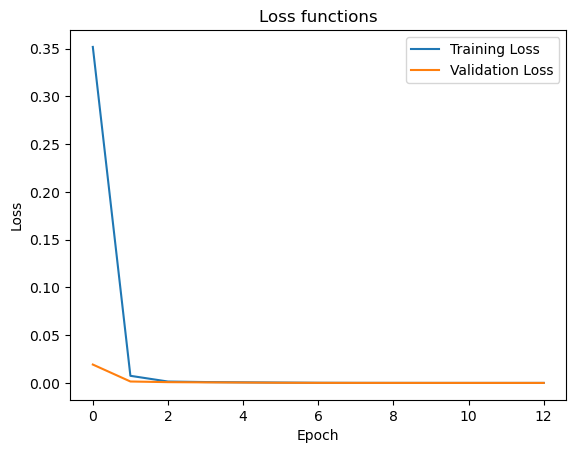

In [30]:
# Evaluation phase
accuracy, avg_loss = evaluate(
    model=best_model_obj['model'],
    ts_dataloader=test_loader,
    criterion=criterion,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# Shows the results
print(f'Best model parameters: {best_model_obj["params"]}')
print(f'Test Loss: {avg_loss:.5f}')
print(f'Test Accuracy: {accuracy:.4f}')
show_plot(best_model_obj['tr_losses'], best_model_obj['vl_losses'])